**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from scipy import optimize
from scipy.optimize import minimize_scalar
import sympy as sm
import pandas as pd
from types import SimpleNamespace
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 


* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:

#We define the variables and parameters 
C = sm.symbols('C', positive = True, real = True) 
G = sm.symbols('G', positive = True, real = True)
kappa = sm.symbols('kappa', positive = True, real = True)
w = sm.symbols('w', positive = True, real = True)
tau = sm.symbols('tau', positive = True, real = True)
v = sm.symbols('v', positive = True, real = True)
a = sm.symbols('a', positive = True, real = True)
L = sm.symbols('L', positive = True, real = True)

wtilde = sm.symbols('wtilde', positive = True, real = True)


#Define objective and budget constraint:
objective = sm.log(C**a*G**(1-a))-v*(L**2/2)
objective

budget_constraint = sm.Eq(kappa+wtilde*L,C)
budget_constraint

# isolate C
C_from_con = sm.solve(budget_constraint, C)
C_from_con[0]

#Substitute C in the objective function
objective_subs = objective.subs(C, C_from_con[0])

#Take the derivative/deriving the FOC
foc = sm.diff(objective_subs, L)

#Solve the FOC wrt. L
sol = sm.solve(sm.Eq(foc,0), L)
sol[0]

-kappa/(2*wtilde) + sqrt(4*a*wtilde**2 + kappa**2*v)/(2*sqrt(v)*wtilde)

The result that we get is the same as the result given in question 1 but the result is visually different from the given result. We could structure it differently and get the we same result. 

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

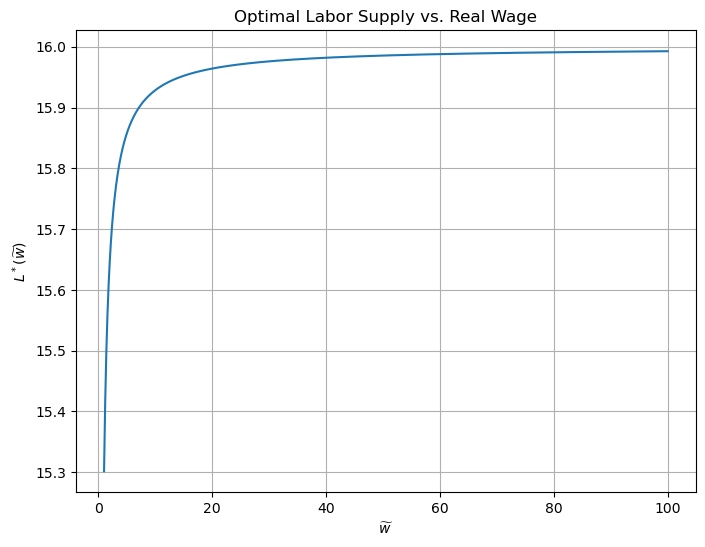

In [3]:
# we first define all of the baseline parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
tau = 0.30
G_values = [1.0, 2.0]
w_values = np.linspace(1, 100, 1000)  # Range of w values for plotting

# We define how we will calculate optimal labor supply L*
def optimal_labor_supply(w):
    tw = (1 - tau) * w
    return (-kappa + np.sqrt(kappa**2 + 4 * alpha / nu * tw**2)) / (2 * tw)

# We set the plot size
plt.figure(figsize=(8, 6))

# We find L_star and plot
L_star = optimal_labor_supply(w_values)

plt.plot(w_values, L_star)
plt.xlabel('$ \widetilde{w} $')
plt.ylabel('$L^*(\widetilde{w})$')
plt.title('Optimal Labor Supply vs. Real Wage')
plt.grid(True)
plt.show()


We see that: 1. Optimal labor supply, L*, is positivly dependent on the wage rate, w, implying that $\frac{\partial L^*(\widetilde{w})}{\partial \widetilde{w}} > 0$. 2. This only continues up until a certain wage level, where we have that: $\frac{\partial L^*(\widetilde{w})}{\partial \widetilde{w}} = 0$.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


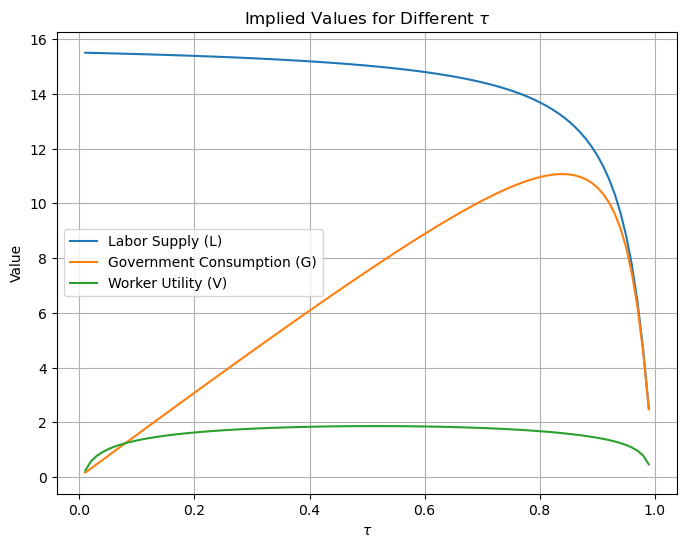

In [4]:
# Remove FutureWarning from append
warnings.simplefilter(action='ignore', category=FutureWarning)

# Initializations
w = 1.0
values = pd.DataFrame(columns=['L_values','U_values', 'G_values', 'tau_values'])

tau_values = np.linspace(0.01, 0.99, 100)  # Grid of tau-values

# Define a utility maximization function
def maximize_utility(w, tau, alpha, kappa, nu):
    # Find optimal labor supply
    L_star = optimal_labor_supply(w)
    
    # Calculate optimal consumption
    C_star = kappa + (1 - tau) * w * L_star

    # Calculate optimal G
    G_star = tau * w * L_star

    # Calculate utility
    utility = np.log(C_star**alpha * G_star**(1 - alpha)) - nu * (L_star**2) / 2

    return L_star, G_star, utility

# We calculate implied L, G, and worker utility for different tau values and store the results ina DF
for tau in tau_values:
    L_star, G_star, utility = maximize_utility(w, tau, alpha, kappa, nu)
    values = values.append({'L_values': L_star, 'U_values': utility, 'G_values': G_star, 'tau_values': tau}, ignore_index=True)

# We plot L, G, and worker utility against tau
plt.figure(figsize=(8, 6))
plt.plot(values['tau_values'], values['L_values'], label='Labor Supply (L)')
plt.plot(values['tau_values'], values['G_values'], label='Government Consumption (G)')
plt.plot(values['tau_values'], values['U_values'], label='Worker Utility (V)')
plt.xlabel('$\\tau$')
plt.ylabel('Value')
plt.title('Implied Values for Different $\\tau$')
plt.legend()
plt.grid(True)
plt.show()

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

The socially optimal tax rate maximizes utility and then government tax revenues:
Optimal tax rate τ: 0.515
Maximum worker utility V: 1.859


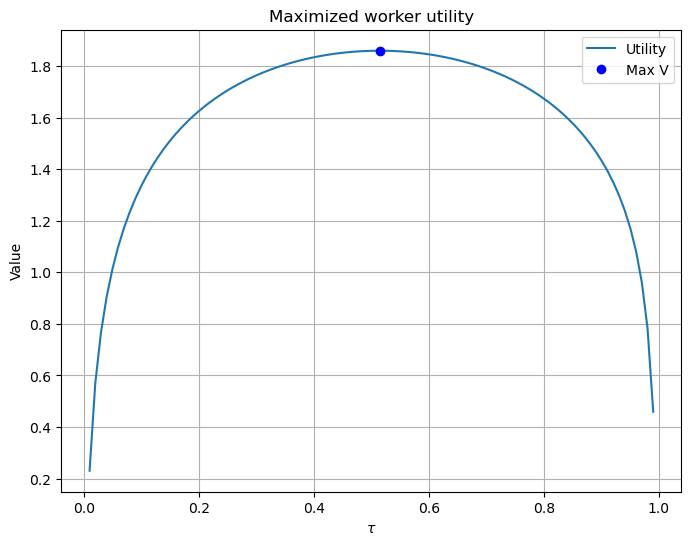

In [5]:
# defining optimal values
max_U = max(values['U_values'])
max_U_index = values['U_values'].idxmax()
tau = values.loc[max_U_index, 'tau_values']
max_G = values.loc[max_U_index, 'G_values']

# print results
print('The socially optimal tax rate maximizes utility and then government tax revenues:')
print(f'Optimal tax rate \u03C4: {tau:.3f}')
print(f'Maximum worker utility V: {max_U:.3f}')

# plot the results
plt.figure(figsize=(8, 6))
plt.plot(values['tau_values'], values['U_values'], label='Utility')
plt.plot(tau, max_U, 'bo', label='Max V')

plt.xlabel('$\\tau$')
plt.ylabel('Value')
plt.title('Maximized worker utility')
plt.legend()
plt.grid(True)
plt.show()


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [22]:
"Calculation of G using the first set of params"
# Set 1 parameters
sigma = 1.001
rho = 1.001
epsilon = 1.0

# We define the new utility function
def utility_function(L, w, tau, G, alpha, sigma, rho, nu, epsilon, kappa):
    G=1
    C = kappa + (1 - tau) * w * L
    utility = ((alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma-1)))**(1 - rho) / (1 - rho) - nu * (L**(1 + epsilon)) / (1 + epsilon)
    return -utility 

# Function for optimization w.r.t L
def find_optimal_labor(w, tau, G, alpha, sigma, rho, nu, epsilon, kappa):
    bounds = [(0, 24)]  # Labor supply bounds [0, 24]
    result = optimize.minimize(utility_function, x0=12, args=(w, tau, G, alpha, sigma, rho, nu, epsilon, kappa), bounds=bounds, method='SLSQP')
    optimal_labor = result.x[0]
    return optimal_labor

# L_1* U_1 for evaluation
L_1 = find_optimal_labor(w, tau, G, alpha, sigma, rho, nu, epsilon, kappa)

# G_1*
G_1= tau*w*L_1

"Calculation of G using the second set of params"
# Set 2 parameters
sigma = 1.5
rho = 1.5

# L_2*
L_2 = find_optimal_labor(w, tau, G, alpha, sigma, rho, nu, epsilon, kappa)

# G_2*
G_2= tau*w*L_2

print(f'G under paramset 1: {G_1:.3f}')
print(f'G under paramset 2: {G_2:.3f}')

G under paramset 1: 7.721
G under paramset 2: 6.583


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [33]:
# Tau under the first set of params
tau_1 =G_1/(w*L_1)
# Tau under the second set of params
tau_2 = G_2/(w*L_2)
print('The socially optimal tax rate is unchanged')
print(f'\u03C4 under paramset 1: {tau_1:.3f}')
print(f'\u03C4 under paramset 2: {tau_2:.3f}')

The socially optimal tax rate is unchanged
τ under paramset 1: 0.515
τ under paramset 2: 0.515


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

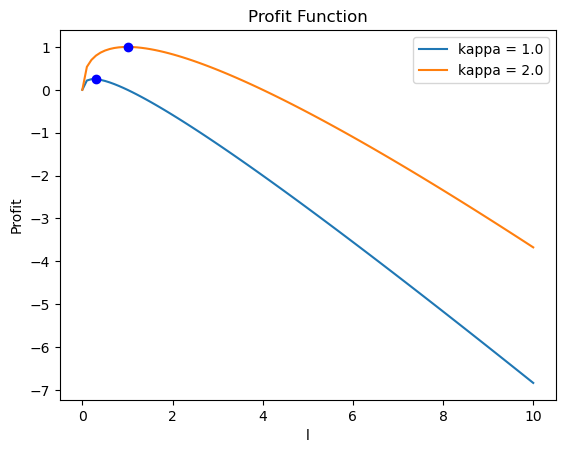

Kappa: 1.0, Optimal l: 0.25
Kappa: 2.0, Optimal l: 1.0


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Set the baseline parameters
eta = 0.5
w = 1.0
# Define the range of l values
l_values = np.linspace(0, 10, 100)

# Calculate the profit function for each l value
profit = lambda l, kappa: kappa * l**(1 - eta) - w * l

# Calculate the profit for kappa = 1 and 2
profit_kappa1 = profit(l_values, 1.0)
profit_kappa2 = profit(l_values, 2.0)

# Find the maximum profit and its corresponding l value for kappa = 1
max_profit_kappa1 = np.max(profit_kappa1)
max_l_kappa1 = l_values[np.argmax(profit_kappa1)]

# Find the maximum profit and its corresponding l value for kappa = 2
max_profit_kappa2 = np.max(profit_kappa2)
max_l_kappa2 = l_values[np.argmax(profit_kappa2)]

# Plot the profit function for kappa = 1 and 2
plt.plot(l_values, profit_kappa1, label='kappa = 1.0')
plt.plot(l_values, profit_kappa2, label='kappa = 2.0')

# Mark the maximum point
plt.plot(max_l_kappa1, max_profit_kappa1, 'bo')
plt.plot(max_l_kappa2, max_profit_kappa2, 'bo')

# Set the x-axis and y-axis labels
plt.xlabel('l')
plt.ylabel('Profit')

# Set the title of the plot
plt.title('Profit Function')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

# Define the kappa values
kappa_values = np.array([1.0, 2.0])

# Calculate the optimal l for each kappa value
optimal_l_values = ((1 - eta) * kappa_values / w) ** (1 / eta)

# Print the optimal l values
for kappa, l in zip(kappa_values, optimal_l_values):
    print(f'Kappa: {kappa}, Optimal l: {l}')

From the profit function showed in the figure, we see that profit is maximized when l is approx 0,25 when kappa is equal to 1, furthermore we see that when kappa is equal to 2, profit is maximized when l is approx 1. When this is compared with the values calculated from the function given, we see that these values correspond to each other.

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [9]:
import numpy as np

# Baseline parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)

K = 150
eta = 0.5  
w = 1

H = 0

for j in range(K):
    epsilon_series = np.random.normal(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=(120))
    kappa = 1
    exvalue = 0

    for t in range(119):
        kappa_t = np.exp(rho * np.log(kappa) + epsilon_series[t-1])
        l_t = ((1 - eta) * kappa_t / w) ** (1 / eta)
        adjustment_cost = iota if l_t != 0 else 0
        profit = kappa_t * l_t**(1 - eta) - w * l_t - adjustment_cost
        exvalue += R**(-t) * profit

    h = exvalue
    H += h

H /= K

H_original = H

print("H:", H_original)




H: 27.56674978682218


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [10]:
import numpy as np

# Baseline parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)

K = 150
eta = 0.5
w = 1

H = 0

for j in range(K):
    epsilon_series = np.random.normal(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=(120))
    kappa = 1
    exvalue = 0
    l_t = np.zeros(120)  # Array to store l_t values
    l_t[0] = 0  # Initial value of l_t

    for t in range(1, 119):
        kappa_t = np.exp(rho * np.log(kappa) + epsilon_series[t-1])

        if abs(l_t[t-1] - ((1 - eta) * kappa_t / w) ** (1 / eta)) > 0.05:
            l_t[t] = ((1 - eta) * kappa_t / w) ** (1 / eta)
        else:
            l_t[t] = l_t[t-1]

        adjustment_cost = iota if l_t[t] != 0 else 0
        profit = kappa_t * l_t[t]**(1 - eta) - w * l_t[t] - adjustment_cost
        exvalue += R**(-t) * profit

    h = exvalue
    H += h

H /= K

print("H (New Policy with Δ = 0.05):", H)

print("H (Previous Policy with Δ = 0):", H_original)

print("Improvement in profitability:", H - H_original)


H (New Policy with Δ = 0.05): 27.26137614337508
H (Previous Policy with Δ = 0): 27.56674978682218
Improvement in profitability: -0.3053736434470977


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

Optimal delta: 0.0
Maximum H: 27.264987391739762


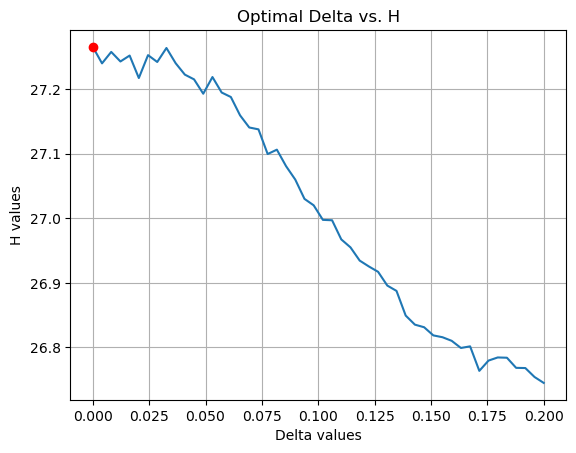

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Baseline parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)

K = 2000
eta = 0.5
w = 1

# Define range of delta values to iterate over
delta_values = np.linspace(0, 0.2, 50)  # Adjust the range as needed

H_values = []
optimal_delta = None
max_H = float("-inf")

for delta in delta_values:
    H = 0

    for j in range(K):
        epsilon_series = np.random.normal(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=(120))
        kappa = 1
        exvalue = 0
        l_t = np.zeros(120)  # Array to store l_t values
        l_t[0] = 0  # Initial value of l_t

        for t in range(1, 119):
            kappa_t = np.exp(rho * np.log(kappa) + epsilon_series[t-1])

            if abs(l_t[t-1] - ((1 - eta) * kappa_t / w) ** (1 / eta)) > delta:
                l_t[t] = ((1 - eta) * kappa_t / w) ** (1 / eta)
            else:
                l_t[t] = l_t[t-1]

            adjustment_cost = iota if l_t[t] != 0 else 0
            profit = kappa_t * l_t[t]**(1 - eta) - w * l_t[t] - adjustment_cost
            exvalue += R**(-t) * profit

        h = exvalue
        H += h

    H /= K
    H_values.append(H)

    if H > max_H:
        max_H = H
        optimal_delta = delta

print("Optimal delta:", optimal_delta)
print("Maximum H:", max_H)

# Create the figure
plt.plot(delta_values, H_values)
plt.plot(optimal_delta, max_H, 'ro')  # Highlight the optimal delta with a red dot
plt.xlabel("Delta values")
plt.ylabel("H values")
plt.title("Optimal Delta vs. H")
plt.grid(True)
plt.show()



**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Baseline parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)

K = 150
eta = 0.5
w = 1

# Define range of delta values to iterate over
delta_values = np.linspace(0, 0.2, 50)  # Adjust the range as needed

H_values = []
optimal_delta = None
max_H = float("-inf")

for delta in delta_values:
    H = 0

    for j in range(K):
        epsilon_series = np.random.normal(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=(120))
        kappa = 1
        exvalue = 0
        l_t = np.zeros(120)  # Array to store l_t values
        l_t[0] = 0  # Initial value of l_t

        adjustment_cost = 0  # Initialize adjustment cost

        for t in range(1, 119):
            kappa_t = np.exp(rho * np.log(kappa) + epsilon_series[t-1])

            if abs(l_t[t-1] - ((1 - eta) * kappa_t / w) ** (1 / eta)) > delta:
                l_t[t] = ((1 - eta) * kappa_t / w) ** (1 / eta)
                if l_t[t] > l_t[t-1]:
                    adjustment_cost += iota  # Positive adjustment cost for increasing labor input
                else:
                    adjustment_cost -= iota  # Negative adjustment cost for decreasing labor input
            else:
                l_t[t] = l_t[t-1]
                adjustment_cost = 0  # No adjustment cost if labor input doesn't change

            profit = kappa_t * l_t[t]**(1 - eta) - w * l_t[t] - adjustment_cost
            exvalue += R**(-t) * profit

        h = exvalue
        H += h

    H /= K
    H_values.append(H)

    if H > max_H:
        max_H = H
        optimal_delta = delta

print("H (New Policy with Δ = 0.05):", H)

print("H (Previous Policy with Δ = 0):", H_original)

print("Improvement in profitability:", H - H_original)




H (New Policy with Δ = 0.05): 27.846796768240953
H (Previous Policy with Δ = 0): 27.56674978682218
Improvement in profitability: 0.28004698141877427


## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [13]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

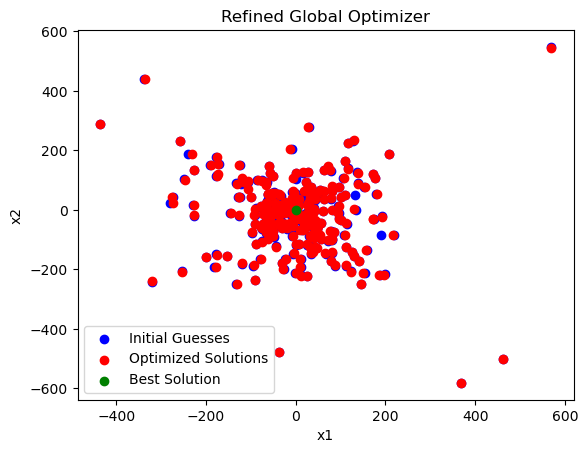


Optimization Result:
Best solution: x* = [-9.53823384e-09 -1.46934426e-08], f(x*) = 0.0


In [14]:
# Our global optimizer function
def refined_global_optimizer(bounds, tolerance, K_warmup, K_max):
    x_best = None  # Initialize the best solution
    f_best = float('inf')  # Initialize the best objective function value as infinity
    
    x_k0_list = []  # List to store x_k0 values for each iteration
    x_k_star_list = []  # List to store x_k* values for each iteration

    for k in range(K_max):
        if k >= K_warmup:  # Check if warm-up iterations have been exceeded
            chi = 0.50 * (2 / (1 + np.exp((k - K_warmup) / 100)))  # Calculate the scaling factor chi
            x_k = chi * np.random.uniform(bounds[0], bounds[1], size=2) + (1 - chi) * x_best  # Generate the weighted initial guess x_k0
        else:
            x_k = np.random.uniform(bounds[0], bounds[1], size=2)  # Generate a random initial guess x_k0
        
        x_k0_list.append(x_k)  # Store the current initial guess x_k0
        
        result = minimize(griewank, x_k, method='BFGS', tol=tolerance)  # Perform optimization with the initial guess x_k0
        x_k_star = result.x  # Get the optimized solution x_k*
        f_k_star = result.fun  # Get the objective function value at x_k*
        
        x_k_star_list.append(x_k_star)  # Store the optimized solution x_k*
        
        if k == 0 or f_k_star < f_best:  # Check if the current solution is the best so far
            x_best = x_k_star  # Update the best solution
            f_best = f_k_star  # Update the best objective function value

        if f_best < tolerance:  # Check if the best objective function value satisfies the tolerance
            break  # If it does, terminate the optimization process

    return x_best, x_k0_list, x_k_star_list  # Return the best solution, x_k0 values, and x_k* values


# Settings
bounds = [-600, 600]
tolerance = 1e-8
K_warmup = 10
K_max = 1000

# Run the optimizer
best_solution, initial_guesses, optimized_solutions = refined_global_optimizer(bounds, tolerance, K_warmup, K_max)

# Convert to NumPy arrays for plotting
x_k0 = np.array(initial_guesses)
x_k_star = np.array(optimized_solutions)

# Plotting the optimization progress
plt.scatter(x_k0[:, 0], x_k0[:, 1], c='b', label='Initial Guesses')
plt.scatter(x_k_star[:, 0], x_k_star[:, 1], c='r', label='Optimized Solutions')
plt.scatter(best_solution[0], best_solution[1], c='g', label='Best Solution')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Refined Global Optimizer')
plt.legend()
plt.show()

print("\nOptimization Result:")
print(f"Best solution: x* = {best_solution}, f(x*) = {griewank(best_solution)}")

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

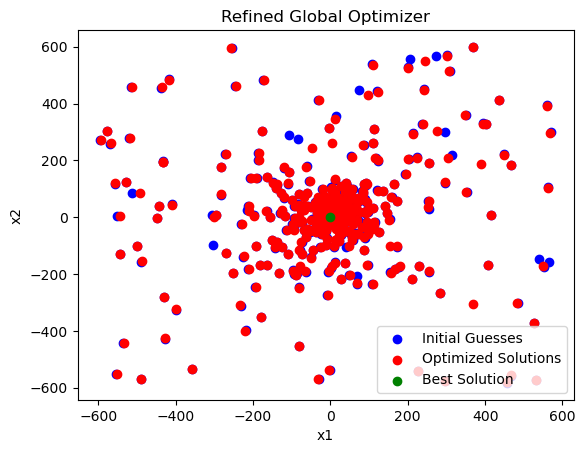


Optimization Result:
Best solution: x* = [-8.9530407e-09  3.9690072e-09], f(x*) = 0.0


In [15]:
"""
To compare the convergence behavior for different values of K and determine 
if setting K_bar = 100 leads to faster convergence, we run the optimizer with  
K_bar=100 and observe the results.
"""

K_warmup = 100

# Run the optimizer
best_solution, initial_guesses, optimized_solutions = refined_global_optimizer(bounds, tolerance, K_warmup, K_max)

# Convert to NumPy arrays for plotting
x_k0 = np.array(initial_guesses)
x_k_star = np.array(optimized_solutions)

# Plotting the optimization progress
plt.scatter(x_k0[:, 0], x_k0[:, 1], c='b', label='Initial Guesses')
plt.scatter(x_k_star[:, 0], x_k_star[:, 1], c='r', label='Optimized Solutions')
plt.scatter(best_solution[0], best_solution[1], c='g', label='Best Solution')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Refined Global Optimizer')
plt.legend()
plt.show()

print("\nOptimization Result:")
print(f"Best solution: x* = {best_solution}, f(x*) = {griewank(best_solution)}")

Comparing the results, we can observe the following:

The convergence is faster because with $\underline{K} = 100$, the optimizer was able to find a solution that satisfies the convergence criteria and has an objective function value of zero. This indicates that the optimizer reached a highly accurate solution more quickly compared to $\underline{K} = 10$, where the objective function value was close to zero but not precisely zero.